### Connect to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/[2023-2024] AN2DL/Lecture 4

### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Load and process the dataset

In [ ]:
# Conditional check for unzipping
unzip = False

# Unzip the 'animals.zip' file if the 'unzip' flag is True
if unzip:
    !unzip animals.zip

# Unzip the 'items.zip' file if the 'unzip' flag is True
    !unzip items.zip

In [ ]:
def load_images_from_folder(folder):
    images = []

    # Iterate through files in the specified folder
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))

        # Normalize image pixel values to a float range [0, 1]
        img = (img / 255).astype(np.float32)

        # Convert image from BGR to RGB
        img = img[...,::-1]

        # Make the image dataset squared
        dim = min(img.shape[:-1])
        img = img[(img.shape[0]-dim)//2:(img.shape[0]+dim)//2, (img.shape[1]-dim)//2:(img.shape[1]+dim)//2, :]

        # Resize the image to 224x224 pixels
        img = tfkl.Resizing(224, 224)(img)

        if img is not None:
            images.append(img)

    return np.array(images)

# Load images from the 'animals/' folder
animals_path = 'animals/'
animals = load_images_from_folder(animals_path)

# Load images from the 'items/' folder
items_path = 'items/'
items = load_images_from_folder(items_path)

In [ ]:
# Number of images to display
num_img = 10

# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(items[i], 0, 255))  # Display clipped item images
    ax.axis('off')
plt.tight_layout()
plt.show()

# Create subplots for displaying animals
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(animals[i], 0, 255))  # Display clipped animal images
    ax.axis('off')
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# Concatenate 'animals' and 'items' arrays along axis 0
X = np.concatenate([animals, items], axis=0)

# Create labels: 1 for 'animals', 0 for 'items'
y = np.concatenate([np.ones(len(animals)), np.zeros(len(items))], axis=0)

# Convert labels to one-hot encoding format
y = tfk.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=60, stratify=np.argmax(y,axis=1))

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=60, stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (120, 224, 224, 3), y_train shape: (120, 2)
X_val shape: (60, 224, 224, 3), y_val shape: (60, 2)
X_test shape: (60, 224, 224, 3), y_test shape: (60, 2)


### Train MobileNetV2 from scratch

In [ ]:
# Create MobileNetV2 model with specified settings
mobile = tfk.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None,
    pooling='avg',
)

# Display the model architecture with input shapes
tfk.utils.plot_model(mobile, show_shapes=True)

In [ ]:
# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(224, 224, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2226434 (8.49 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
8/8 [==============================] - 38s 444ms/step - loss: 0.9253 - accuracy: 0.5250 - val_loss: 0.6935 - val_accuracy: 0.5000
Epoch 2/200
8/8 [==============================] - 1s 84ms/step - loss: 0.6470 - accuracy: 0.6750 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/200
8/8 [==============================] - 1s 91ms/step - loss: 0.4697 - accuracy: 0.7917 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/200
8/8 [==============================] - 1s 93ms/step - loss: 0.4660 - accuracy: 0.8000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/200
8/8 [==============================] - 1s 87ms/step - loss: 0.3639 - accuracy: 0.8333 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/200
8/8 [==============================] - 1s 85ms/step - loss: 0.3245 - accuracy: 0.8583 - val_loss: 0.6937 - val_accuracy: 0.5000
Epoch 7/200
8/8 [==============================] - 1s 85ms/step - loss: 0.1826 - accuracy: 0.9250 - val_loss: 0.6979 - val_accuracy: 0.5000
Epoch 8/200
8/8 [=

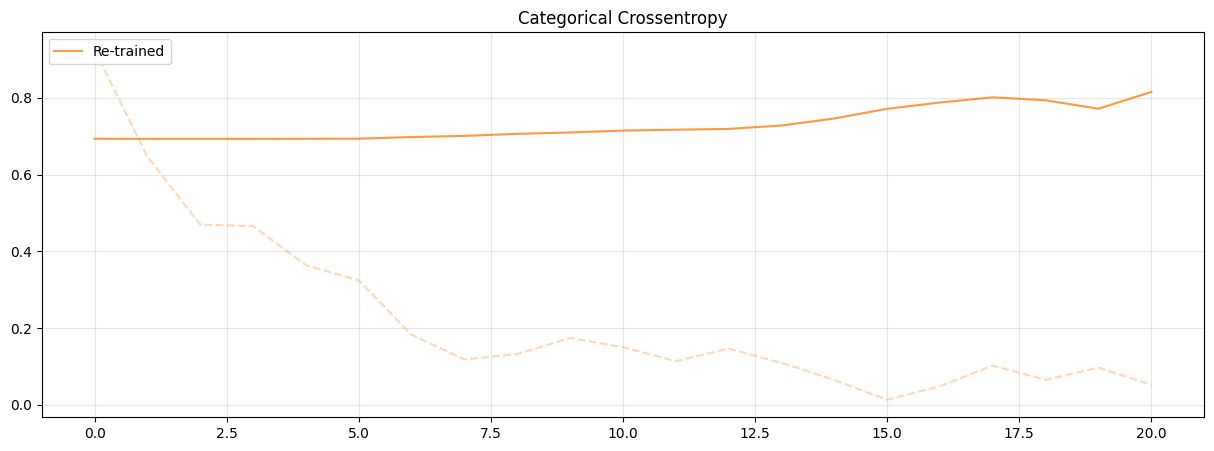

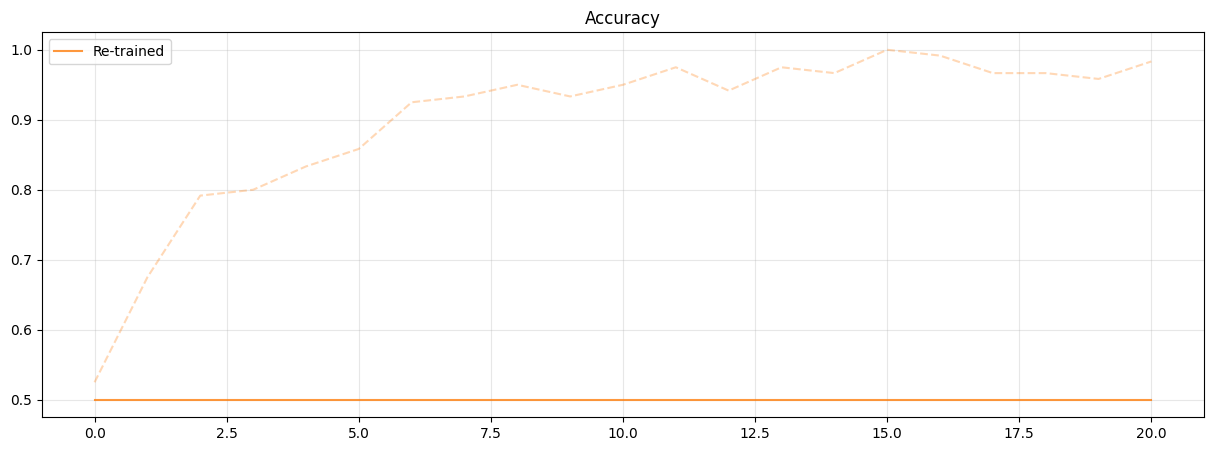

In [ ]:
# Plot the re-trained MobileNetV2 training history
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

## Transfer Learning
Leveraging pre-trained network for a different classification problem
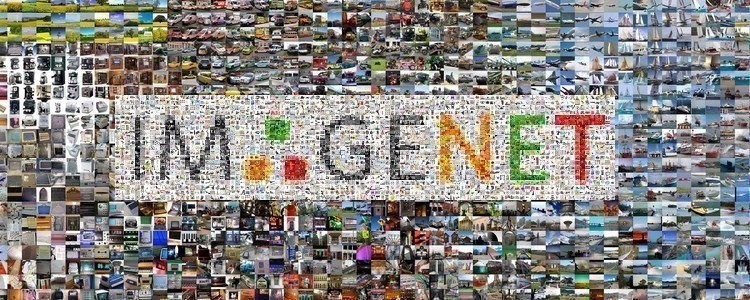

9406464/9406464 [==============================] - 1s 0us/step


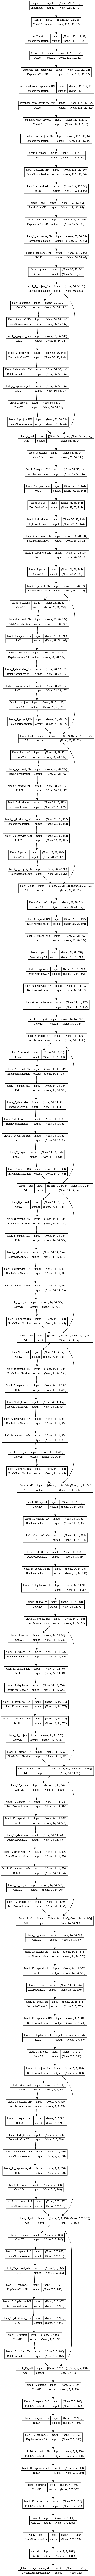

In [ ]:
mobile = tfk.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

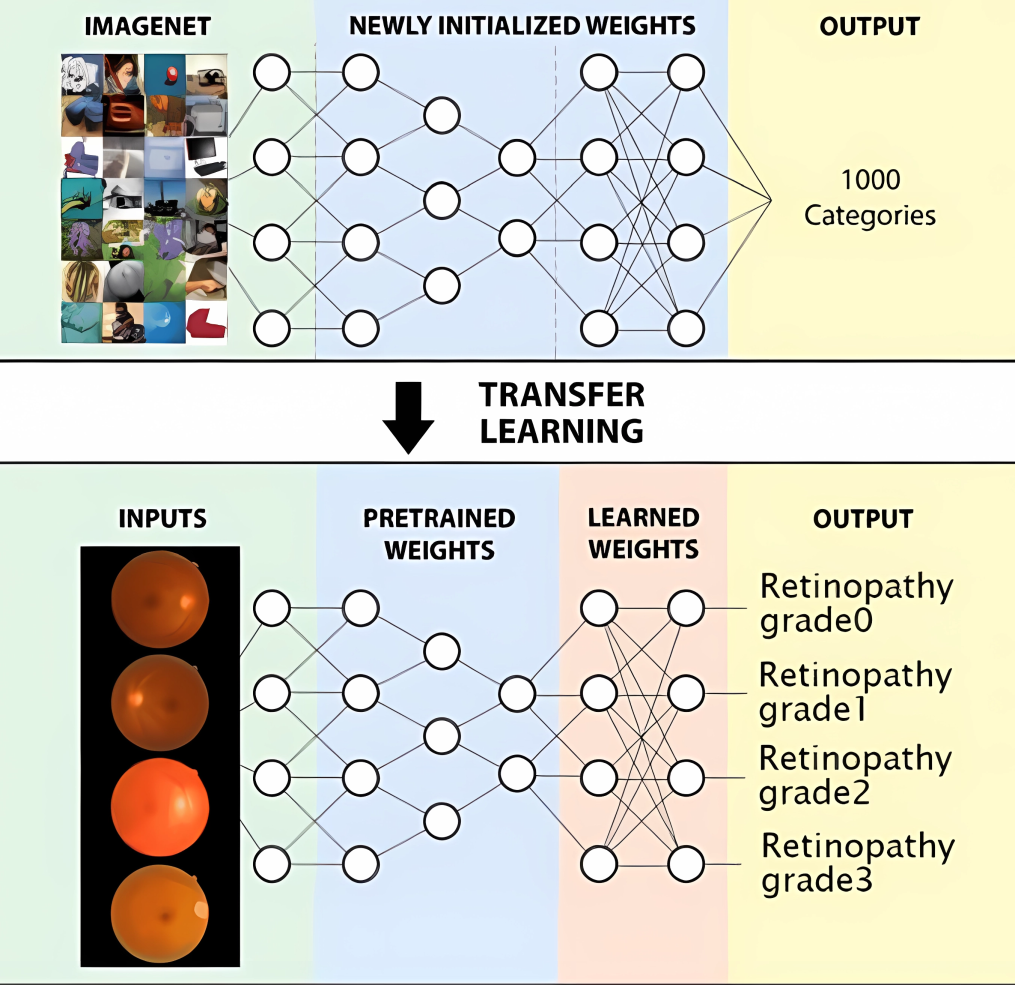

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False

# Create an input layer with shape (224, 224, 3)
inputs = tfk.Input(shape=(224, 224, 3))
# Connect MobileNetV2 to the input
x = mobile(inputs)
# Add a Dense layer with 2 units and softmax activation as the classifier
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
8/8 [==============================] - 5s 211ms/step - loss: 0.7766 - accuracy: 0.5583 - val_loss: 0.6436 - val_accuracy: 0.6500
Epoch 2/200
8/8 [==============================] - 0s 57ms/step - loss: 0.5481 - accuracy: 0.7583 - val_loss: 0.6167 - val_accuracy: 0.6333
Epoch 3/200
8/8 [==============================] - 0s 63ms/step - loss: 0.4012 - accuracy: 0.8667 - val_loss: 0.5877 - val_accuracy: 0.6833
Epoch 4/200
8/8 [==============================] - 0s 46ms/step - loss: 0.3002 - accuracy: 0.9250 - val_loss: 0.5744 - val_accuracy: 0.6667
Epoch 5/200
8/8 [==============================] - 0s 51ms/step - loss: 0.2442 - accuracy: 0.9667 - val_loss: 0.5697 - val_accuracy: 0.6667
Epoch 6/200
8/8 [==============================] - 0s 61ms/step - loss: 0.1931 - accuracy: 0.9833 - val_loss: 0.5477 - val_accuracy: 0.7000
Epoch 7/200
8/8 [==============================] - 0s 46ms/step - loss: 0.1637 - accuracy: 0.9917 - val_loss: 0.5445 - val_accuracy: 0.7000
Epoch 8/200
8/8 [==

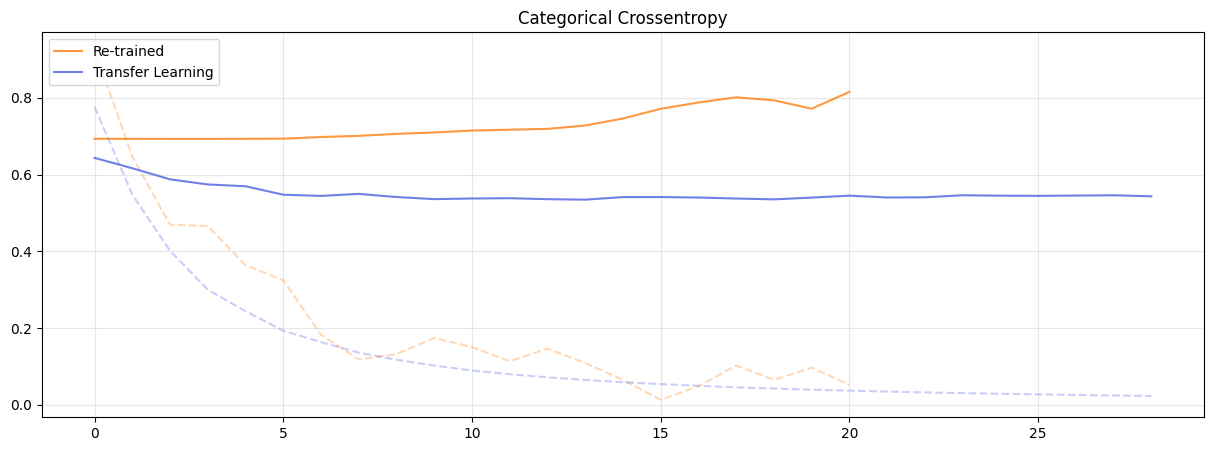

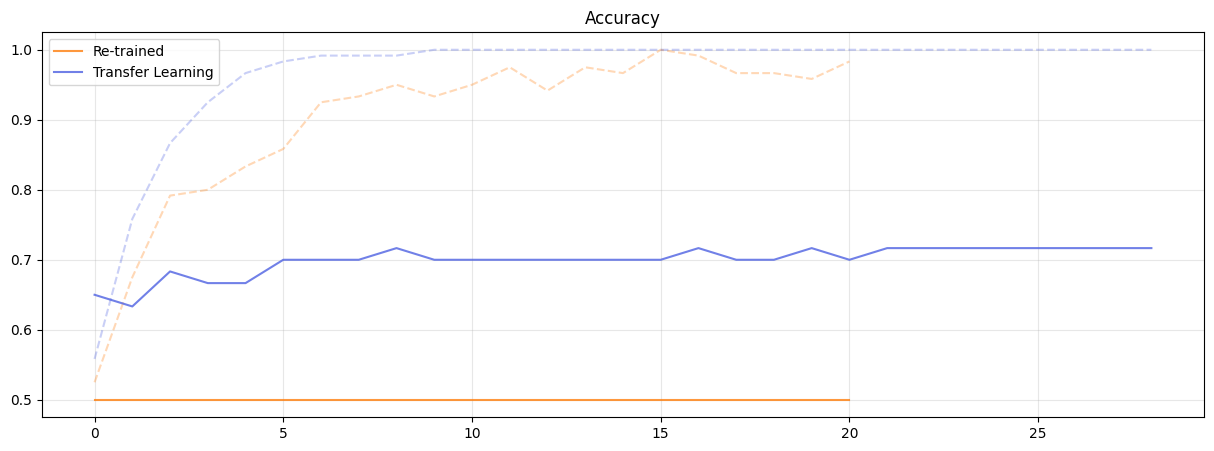

In [ ]:
# Plot the re-trained and the transfer learning MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Save the best model
tl_model.save('TransferLearningModel')
del tl_model

## Fine Tuning
Training also the backbone network. To this purpose it is better to
1.   Perform transfer learning, namely train the new classification head only
2.   Unfreeze the backbone layers (or possibly a few of them depending on the amount of training data) and train the entire netrwork. Note that the classification head needs to be a properly trained model.



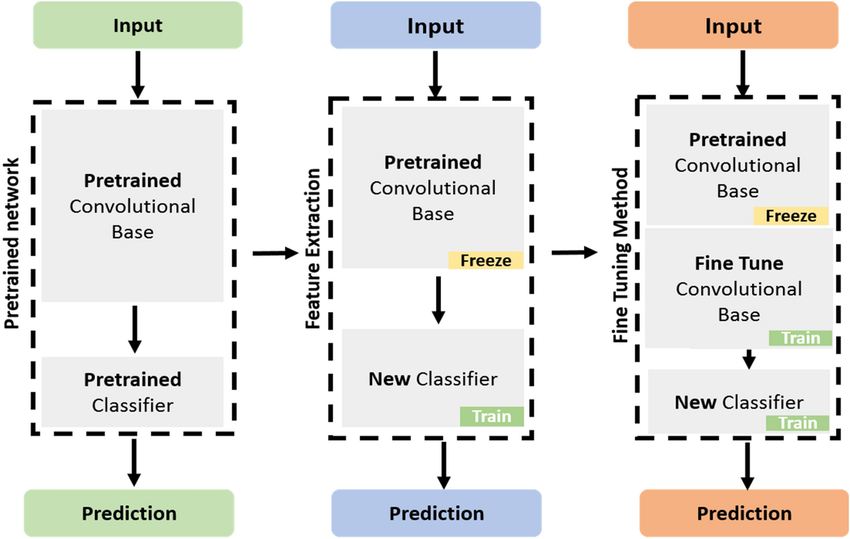

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('TransferLearningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [ ]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('mobilenetv2_1.00_224').trainable = True
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers):
   print(i, layer.name, layer.trainable)

0 input_3 True
1 Conv1 True
2 bn_Conv1 True
3 Conv1_relu True
4 expanded_conv_depthwise True
5 expanded_conv_depthwise_BN True
6 expanded_conv_depthwise_relu True
7 expanded_conv_project True
8 expanded_conv_project_BN True
9 block_1_expand True
10 block_1_expand_BN True
11 block_1_expand_relu True
12 block_1_pad True
13 block_1_depthwise True
14 block_1_depthwise_BN True
15 block_1_depthwise_relu True
16 block_1_project True
17 block_1_project_BN True
18 block_2_expand True
19 block_2_expand_BN True
20 block_2_expand_relu True
21 block_2_depthwise True
22 block_2_depthwise_BN True
23 block_2_depthwise_relu True
24 block_2_project True
25 block_2_project_BN True
26 block_2_add True
27 block_3_expand True
28 block_3_expand_BN True
29 block_3_expand_relu True
30 block_3_pad True
31 block_3_depthwise True
32 block_3_depthwise_BN True
33 block_3_depthwise_relu True
34 block_3_project True
35 block_3_project_BN True
36 block_4_expand True
37 block_4_expand_BN True
38 block_4_expand_relu Tru

In [ ]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('mobilenetv2_1.00_224').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_3 False
1 Conv1 False
2 bn_Conv1 False
3 Conv1_relu False
4 expanded_conv_depthwise False
5 expanded_conv_depthwise_BN False
6 expanded_conv_depthwise_relu False
7 expanded_conv_project False
8 expanded_conv_project_BN False
9 block_1_expand False
10 block_1_expand_BN False
11 block_1_expand_relu False
12 block_1_pad False
13 block_1_depthwise False
14 block_1_depthwise_BN False
15 block_1_depthwise_relu False
16 block_1_project False
17 block_1_project_BN False
18 block_2_expand False
19 block_2_expand_BN False
20 block_2_expand_relu False
21 block_2_depthwise False
22 block_2_depthwise_BN False
23 block_2_depthwise_relu False
24 block_2_project False
25 block_2_project_BN False
26 block_2_add False
27 block_3_expand False
28 block_3_expand_BN False
29 block_3_expand_relu False
30 block_3_pad False
31 block_3_depthwise False
32 block_3_depthwise_BN False
33 block_3_depthwise_relu False
34 block_3_project False
35 block_3_project_BN False
36 block_4_expand False
37 block_4_expa

In [ ]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 200,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
8/8 [==============================] - 6s 216ms/step - loss: 0.1338 - accuracy: 0.9833 - val_loss: 0.4872 - val_accuracy: 0.7500
Epoch 2/200
8/8 [==============================] - 1s 68ms/step - loss: 0.1051 - accuracy: 0.9833 - val_loss: 0.4428 - val_accuracy: 0.7667
Epoch 3/200
8/8 [==============================] - 0s 59ms/step - loss: 0.0630 - accuracy: 1.0000 - val_loss: 0.4097 - val_accuracy: 0.8000
Epoch 4/200
8/8 [==============================] - 1s 70ms/step - loss: 0.1041 - accuracy: 0.9750 - val_loss: 0.3886 - val_accuracy: 0.8167
Epoch 5/200
8/8 [==============================] - 1s 72ms/step - loss: 0.0656 - accuracy: 0.9917 - val_loss: 0.3697 - val_accuracy: 0.8333
Epoch 6/200
8/8 [==============================] - 0s 64ms/step - loss: 0.0456 - accuracy: 1.0000 - val_loss: 0.3533 - val_accuracy: 0.8333
Epoch 7/200
8/8 [==============================] - 0s 59ms/step - loss: 0.0418 - accuracy: 1.0000 - val_loss: 0.3392 - val_accuracy: 0.8333
Epoch 8/200
8/8 [==

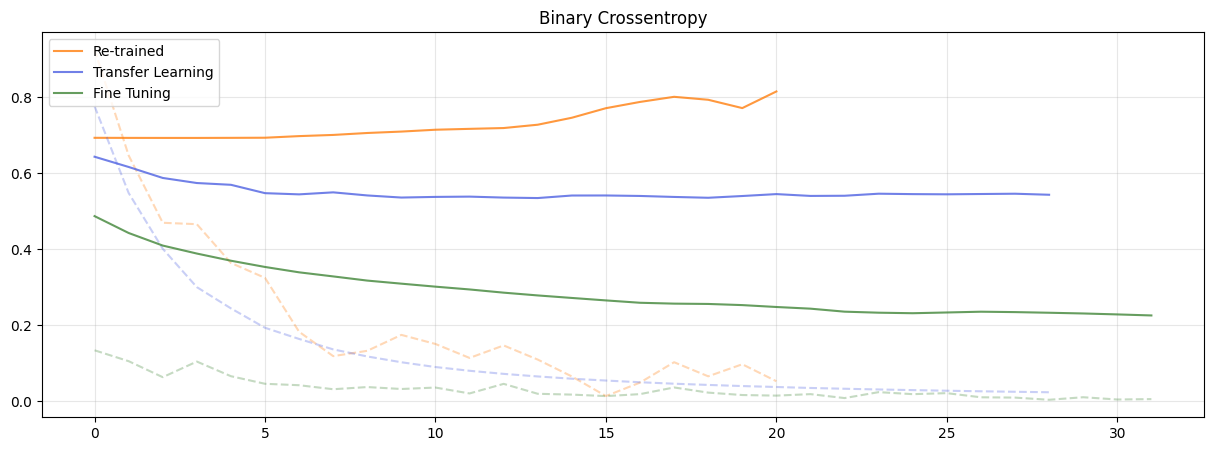

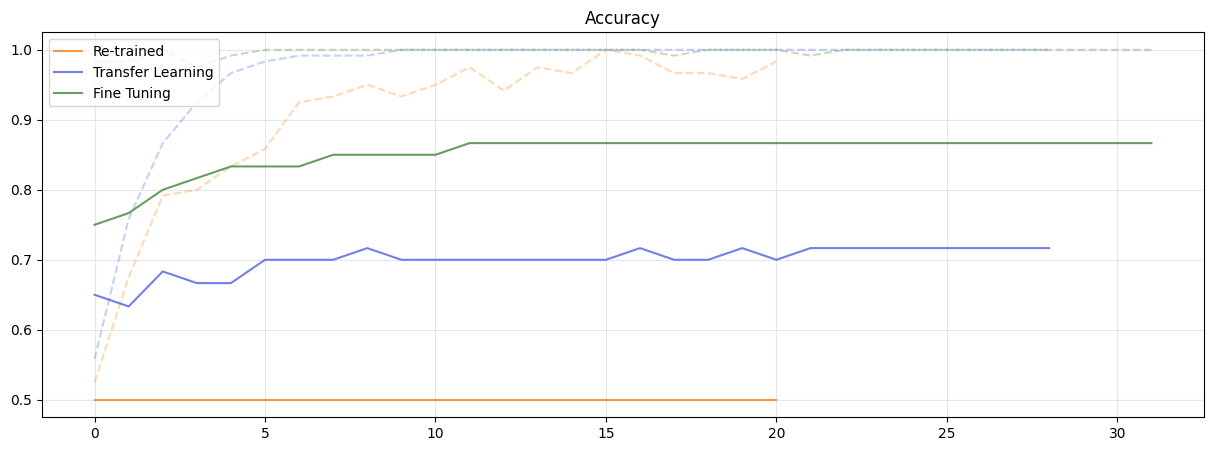

In [ ]:
# Plot the re-trained, the transfer learning and the fine-tuned MobileNetV2 training histories
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['loss'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_loss'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Re-trained', alpha=.8, color='#ff7f0e')
plt.plot(tl_history['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Transfer Learning', alpha=.8, color='#4D61E2')
plt.plot(ft_history['accuracy'], alpha=.3, color='#408537', linestyle='--')
plt.plot(ft_history['val_accuracy'], label='Fine Tuning', alpha=.8, color='#408537')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9000


In [ ]:
# Save the best model
ft_model.save('FineTuningModel')
del ft_model

## Test on your own data

In [ ]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('FineTuningModel')
ft_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 1208642 (4.61 MB)
Non-trainable params: 1051904 (4.01 MB)
_________________________________________________________________


In [ ]:
test_path = 'test_images/'
test = load_images_from_folder(test_path)
test.shape

(4, 224, 224, 3)

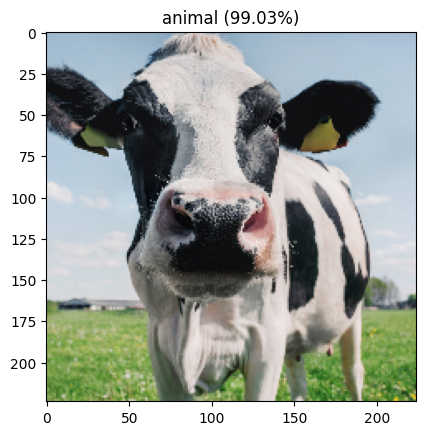

In [ ]:
# predict the test image
test_predictions = ft_model.predict(preprocess_input(test*255), verbose=0)

index = 2
prediction = test_predictions[index]

if prediction[0] >= prediction[1]:
    label = 'item'
    probability = float("{:.{}f}".format(prediction[0], 4))*100

else:
    label = 'animal'
    probability = float("{:.{}f}".format(prediction[1], 4))*100

plt.title(f'{label} ({probability}%)')
plt.imshow(np.squeeze(test[index]))
plt.show()

### TODO Exercise
Practice the various transformations and create your own successful preprocessing pipeline.

What happens if you combine augmentation techniques with fine tuning?



*Credits: Eugenio Lomurno, 📧 eugenio.lomurno@polimi.it*